In [1]:
import numpy as np
import os
from qcodes import Station
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.logger.logger import start_all_logging
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
import matplotlib.pyplot as plt
import scipy.signal as sp
from lab_qcodes import *

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200525-20392-qcodes.log


In [2]:
# Sempre importante iniciar o logging
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200525-20392-qcodes.log


In [3]:
sigma = 10
omega0 = 250
Q = omega0/sigma

f = lambda x: np.arctan((x-omega0)/(sigma/2))/np.pi+1/2
freqs = np.linspace(1,500,1000)

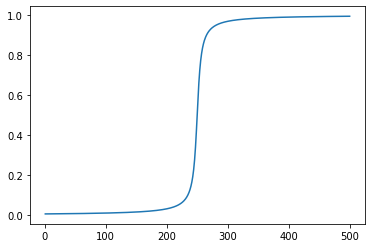

In [4]:
plt.plot(freqs,f(freqs))

# Teste

In [5]:
PSG1 = DummySignalGenerator("SignalGenerator1",noise_function=np.zeros)
PSG2 = DummySignalGenerator("SignalGenerator2",noise_function=np.zeros)
PSG3 = DummySignalGenerator("SignalGenerator3",noise_function=np.zeros)
osc = DummyOscilloscope('oscilloscope')


In [6]:
aDUT = DUT("DUT",PSG1)
circuit = HomodyneCircuit("circuit",aDUT,PSG2)
circuit2 = HomodyneCircuit("circuit2",PSG1,PSG2)

In [7]:
osc.ch1.n_points(5000)
osc.ch2.n_points(5000)
osc.ch3.n_points(5000)
osc.ch4.n_points(5000)

osc.ch1.connect_inst(aDUT)
osc.ch2.connect_inst(PSG2)
osc.ch3.connect_inst(circuit)
osc.ch4.connect_inst(circuit2)
osc.ch1.t_start.set(-10)
osc.ch1.t_stop.set(10)
osc.ch2.t_start.set(-10)
osc.ch2.t_stop.set(10)
osc.ch3.t_start.set(-10)
osc.ch3.t_stop.set(10)
osc.ch4.t_start.set(-10)
osc.ch4.t_stop.set(10)


# Homodyne 

In [8]:
amp = 1
PSG1.amp(amp)
PSG2.amp(amp)

# Teste Medida 

In [9]:
# Station representa um conjunto de instrumentos
station = Station()
station.snapshot()

{'instruments': {},
 'parameters': {},
 'components': {},
 'config': None,
 'default_measurement': []}

In [10]:
station.add_component(osc)

'oscilloscope'

In [11]:
# Criar um database
initialise_or_create_database_at("~/teste.db")

In [12]:
#Definir um experimento
exp = load_or_create_experiment(experiment_name='osc_teste dut',
                                sample_name="osc teste 1")

In [24]:
def calculateGain():
    Y = osc.ch3.wavesample()
    n_mean = int(len(Y)/2)
    value = 2*np.mean(Y[n_mean:])
    value = 10*np.log(np.power(value,2))
    return value

def calculatePhaseGain():
    Y = osc.ch3.wavesample()
    n_mean = int(len(Y)/2)
    value = 2*np.mean(Y[n_mean:])
    return value

phaseGain = Parameter('phaseGain',
                  label='Phase Gain',
                  unit='Degree',
                  get_cmd=calculatePhaseGain)

gain = Parameter('gain',
                  label='gain',
                  unit='dB',
                  get_cmd=calculateGain)

GAIN

In [ ]:
# Medida de fato
meas = Measurement(exp=exp, station=station)

meas.register_parameter(PSG1.freq)
meas.register_parameter(phaseGain, setpoints=[PSG1.freq])

aDUT.omega0(200)
PSG2.phase(np.pi/2)

with meas.run() as datasaver:
    for aFreq in np.linspace(1,500,500):
        PSG1.freq(aFreq)
        PSG2.freq(aFreq)
        datasaver.add_result((phaseGain, phaseGain()), (PSG1.freq, PSG1.freq()))
        
dataset = datasaver.dataset

PHASE

In [32]:
# Medida de fato
meas = Measurement(exp=exp, station=station)

meas.register_parameter(PSG1.freq)
meas.register_parameter(phaseGain, setpoints=[PSG1.freq])

aDUT.omega0(200)
PSG2.phase(np.pi/2)

with meas.run() as datasaver:
    for aFreq in np.linspace(1,500,500):
        PSG1.freq(aFreq)
        PSG2.freq(aFreq)
        datasaver.add_result((phaseGain, phaseGain()), (PSG1.freq, PSG1.freq()))
        
dataset = datasaver.dataset

Starting experimental run with id: 165. 


([<matplotlib.axes._subplots.AxesSubplot at 0x135c0b57688>], [None])

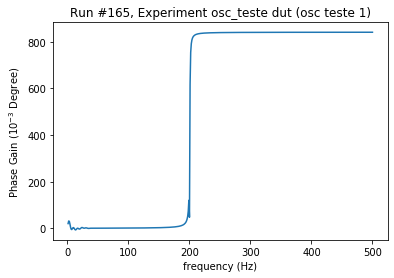

In [33]:
plot_dataset(dataset)

lista de experimentos

In [2]:
import qcodes as qc
from qcodes.dataset.plotting import plot_dataset

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200515-288-qcodes.log


In [78]:
qc.initialise_or_create_database_at("~/teste.db")

In [3]:
experiments = qc.experiments()
for exp in experiments:
    print(exp.name)

dataset_context_manager


In [80]:
use_exp = experiments[-1];use_exp

osc outro dut 2#osc outro dut teste background#9@C:\Users\lucam\teste.db
------------------------------------------------------------------------
74-results-1-SignalGenerator1_freq,gain-500

In [81]:
use_exp.data_sets()

[results #74@C:\Users\lucam\teste.db
 -----------------------------------
 SignalGenerator1_freq - numeric
 gain - numeric]

In [82]:
dataset = qc.load_by_run_spec(experiment_name=use_exp.name)

([<matplotlib.axes._subplots.AxesSubplot at 0x19610d01588>], [None])

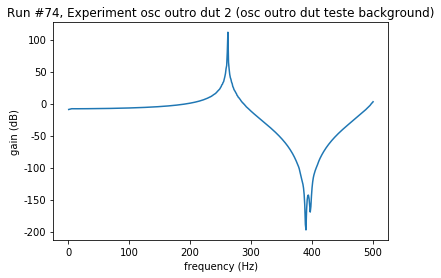

In [91]:
qc.dataset.plotting.plot_dataset(dataset)

real time plot

In [1]:
from jupyterplot import ProgressPlot
import qcodes as qc
import numpy as np
import time

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200515-14396-qcodes.log


In [2]:
qc.initialise_or_create_database_at("~/teste.db")

In [3]:
dataset = qc.load_by_run_spec(experiment_name='osc realtime intro 2')

In [4]:
pp = ProgressPlot(x_iterator=False,x_lim=[0, 500], y_lim=[-200, 200])

Y = dataset.get_parameter_data('gain')['gain']['gain']
X = dataset.get_parameter_data('gain')['gain']['SignalGenerator1_freq']
aLen = len(Y)

for i in range(0,aLen):
        pp.update(X[i],Y[i])

while aLen != 500:
    time.sleep(0.1)
    
    Y = dataset.get_parameter_data('gain')['gain']['gain']
    X = dataset.get_parameter_data('gain')['gain']['SignalGenerator1_freq']

    newLen = len(Y)
    for i in range(aLen,newLen):
        pp.update(X[i],Y[i])
        
    aLen = newLen
    
pp.finalize()